In [244]:
import os
import math
import pandas as pd
import numpy as np
import seaborn as sns
from pandas import datetime
from matplotlib import pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score
from sklearn.multioutput import RegressorChain
from sklearn.multioutput import MultiOutputRegressor
from sklearn.model_selection import GridSearchCV
from functions import *

In [245]:
train = pd.read_csv("../data/train_nocat_hh.csv", index_col = 'tstp')
test = pd.read_csv("../data/test_nocat_hh.csv", index_col = 'tstp')

In [246]:
train = extract_dmhq(train)
test = extract_dmhq(test)

In [247]:
cols = train.columns[:8]

### Creat lag ahead scenarios

In [248]:
ftrain, ttrain = feature_target_construct(train, 96, 96, 30, cols, 2)
ftest, ttest = feature_target_construct(test, 96, 96, 30, cols, 2)

In [249]:
feature_list = list(ftrain.columns)

### Seeking outliers

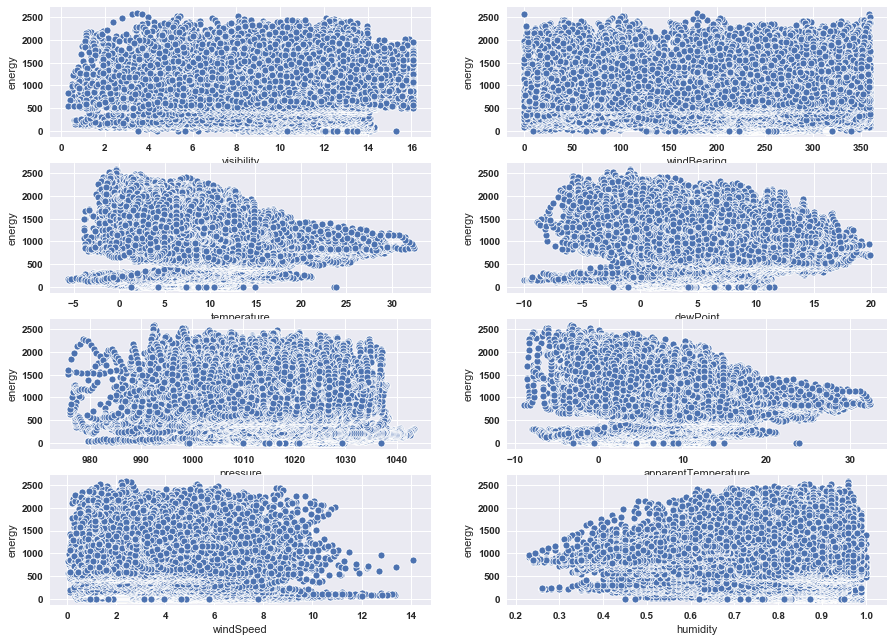

In [170]:
scatter_plot(train)

### Distribution

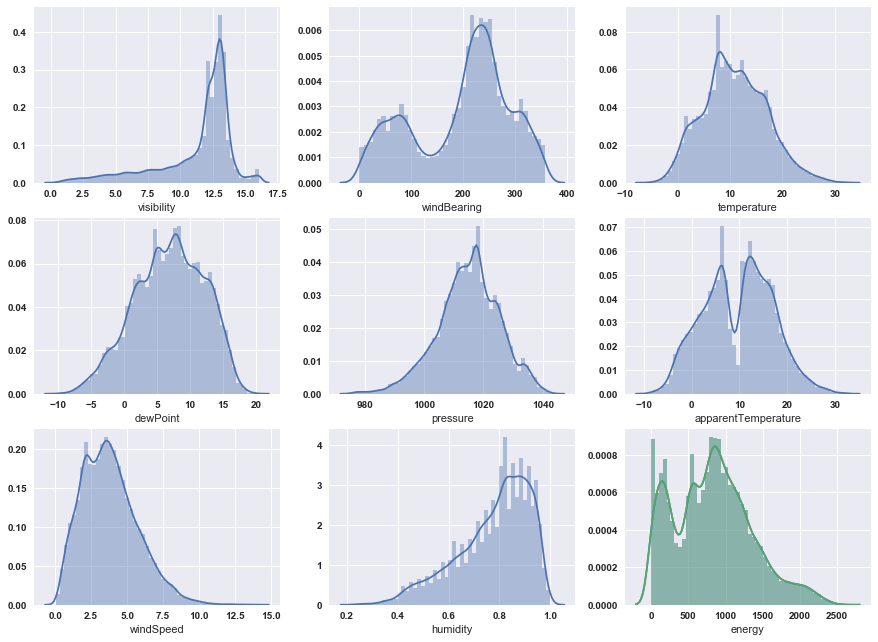

In [97]:
distri_plot(train)

### Feature Selection

In [250]:
from sklearn.tree import ExtraTreeRegressor
from sklearn.feature_selection import SelectFromModel


reg = ExtraTreeRegressor(criterion='mse', 
                         max_depth=None, min_samples_split=3, 
                         min_samples_leaf=10, min_weight_fraction_leaf=0.0, 
                         max_features='auto', max_leaf_nodes=None, 
                         min_impurity_decrease=0.0, min_impurity_split=None, 
                         random_state=31, 
                         ccp_alpha=0.0).fit(ftrain.drop(['LCLid'], axis = 1), ttrain)
model = SelectFromModel(reg, prefit=True)
cols = model.get_support(indices=True)
mt_feature = model.transform(ftrain.drop(['LCLid'], axis = 1))

In [251]:
# Get numerical feature importances
importances = list(reg.feature_importances_)
# List of tuples with variable and importance
feature_importances = [(feature, round(importance, 2)) for feature, importance in zip(feature_list, importances)]
# Sort the feature importances by most important first
feature_importances = sorted(feature_importances, key = lambda x: x[1], reverse = True)
# Print out the feature and importances 
for pair in feature_importances:
    print('Variable: {:20} Importance: {}'.format(*pair))

Variable: energy1(t-33)        Importance: 0.47
Variable: hour                 Importance: 0.11
Variable: apparentTemperature1(t-30) Importance: 0.09
Variable: energy1(t-62)        Importance: 0.04
Variable: energy1(t-21)        Importance: 0.03
Variable: energy1(t-5)         Importance: 0.03
Variable: energy1(t-47)        Importance: 0.02
Variable: energy1(t-23)        Importance: 0.02
Variable: energy1(t-13)        Importance: 0.02
Variable: energy1(t-51)        Importance: 0.01
Variable: energy1(t-40)        Importance: 0.01
Variable: energy1(t-38)        Importance: 0.01
Variable: energy1(t-32)        Importance: 0.01
Variable: energy1(t-29)        Importance: 0.01
Variable: energy1(t-28)        Importance: 0.01
Variable: energy1(t-22)        Importance: 0.01
Variable: energy1(t-18)        Importance: 0.01
Variable: energy1(t-15)        Importance: 0.01
Variable: energy1(t-7)         Importance: 0.01
Variable: energy1(t-1)         Importance: 0.01
Variable: month                Imp

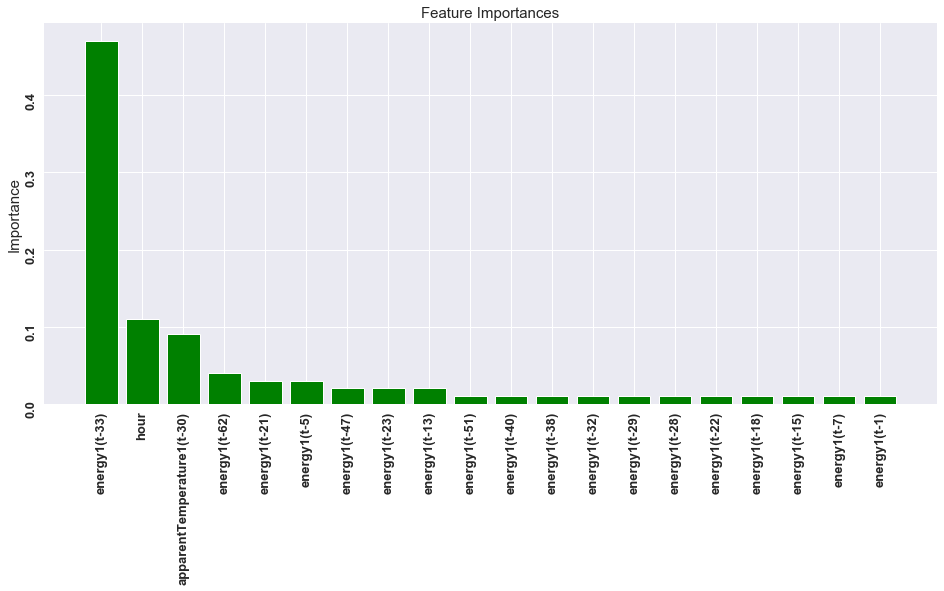

In [252]:
# important features
score = [i[1] for i in feature_importances if i[1] >= 0.01]
picked_features = [i[0] for i in feature_importances if i[1] >= 0.01]
# list of x locations for plotting
x_values = list(range(len(a)))
# Make a bar chart
fig = plt.figure(figsize=(16,7))
font = {'size'   : 15}
plt.rc('font', **font)
plt.bar(x_values, score, orientation = 'vertical', color = 'g', edgecolor = 'w', linewidth = 1)
# Tick labels for x axis
plt.xticks(x_values, picked_features, rotation=90, fontsize = 13)
plt.yticks(rotation='vertical', fontsize = 13)
# Axis labels and title
plt.ylabel('Importance',**font); 
plt.title('Feature Importances',**font);


In [253]:
pftrain = ftrain[picked_features]
pftest = ftest[picked_features]

### Scaling 

In [254]:
from sklearn.preprocessing import MinMaxScaler

mmscaler = MinMaxScaler() ## will be used later in test set
mmscaler.fit(pftrain)
ftrain = mmscaler.transform(pftrain)
ftest = mmscaler.transform(pftest)

### Standardization

In [266]:
rng = np.random.RandomState(304)
qt = QuantileTransformer(n_quantiles=500, output_distribution='normal',random_state=rng)
qt.fit(pftrain)
pftrain = qt.transform(pftrain)
pftest = qt.transform(pftest)

### Extra Trees Regression

In [267]:
# Tree based feature selection
from sklearn.tree import ExtraTreeRegressor
from sklearn.feature_selection import SelectFromModel
etr = ExtraTreeRegressor(criterion='mse', 
                         max_depth=None,
                         min_samples_split=15, 
                         min_samples_leaf=2, min_weight_fraction_leaf=0.0, 
                         max_features='auto', max_leaf_nodes=None, 
                         min_impurity_decrease=0.3, min_impurity_split=None, 
                         random_state=31, 
                         ccp_alpha=0.5)
X = pftrain
y = ttrain
train_X, val_X, train_y, val_y = train_test_split(X, y, train_size = 0.7, test_size = 0.3)


%time etr.fit(train_X, train_y)

CPU times: user 215 ms, sys: 5.04 ms, total: 220 ms
Wall time: 220 ms


ExtraTreeRegressor(ccp_alpha=0.5, criterion='mse', max_depth=None,
                   max_features='auto', max_leaf_nodes=None,
                   min_impurity_decrease=0.3, min_impurity_split=None,
                   min_samples_leaf=2, min_samples_split=15,
                   min_weight_fraction_leaf=0.0, random_state=31,
                   splitter='random')

In [ ]:
param_grid = {'ccp_alpha': [0.1,0.2,0.3,0.4,0.5],
              'max_depth': [1,3,5,7,9,11,13],
              'min_samples_split' : [1,3,5,7,9,11,13,15,17,19],
              'min_samples_leaf': [1,2,3,4,5],
              'min_impurity_decrease': [0.1,0.3,0.5,0.7,0.9]}

gcv = GridSearchCV(etr, 
             param_grid, 
             scoring=None, 
             n_jobs=4, 
             iid='deprecated', 
             refit=True, 
             cv=10, 
             verbose=0, 
             pre_dispatch='2*n_jobs', 
             return_train_score=False)
%time gcv.fit(train_X, train_y)


In [282]:
etr_best = gcv.best_estimator_
%time etr_best.fit(train_X, train_y)

CPU times: user 189 ms, sys: 3.22 ms, total: 192 ms
Wall time: 190 ms


ExtraTreeRegressor(ccp_alpha=0.5, criterion='mse', max_depth=13,
                   max_features='auto', max_leaf_nodes=None,
                   min_impurity_decrease=0.3, min_impurity_split=None,
                   min_samples_leaf=2, min_samples_split=19,
                   min_weight_fraction_leaf=0.0, random_state=31,
                   splitter='random')

### Validation set

In [284]:
ypred = etr_best.predict(val_X)
o_y = np.transpose(val_y.iloc[:,:].to_numpy())
p_y = np.transpose(ypred[:,:])
get_eval(o_y, p_y)

MSE: 14978.534994192789
MAE: 68.33627012485775
r2_score: 0.8269747146630272


### Testing set

In [285]:
## feature scaling
# single_test = pd.concat([single_wt, ahead_et], axis = 1) ## without weather recency effect
## with weather recency effect
ypred_t = etr_best.predict(pftest)
o_y = np.transpose(ttest.iloc[:,:].to_numpy())
p_y = np.transpose(ypred_t[:,:])
get_eval(o_y, p_y)

MSE: 18372.643126237952
MAE: 101.20942812361685
r2_score: 0.8826423198406691


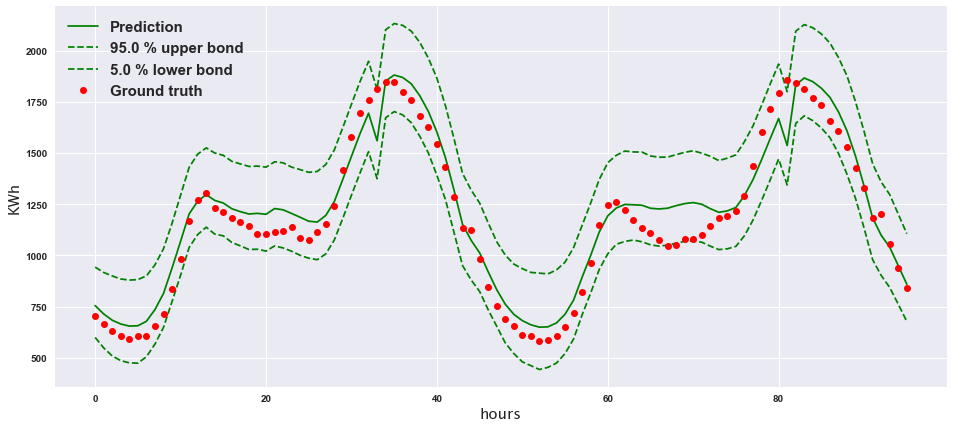

In [287]:
plot_conf(ttest, ypred_t, 100, 1.645)

### HistGradientBoostingRegression

In [228]:
from sklearn.experimental import enable_hist_gradient_boosting 
from sklearn.ensemble import HistGradientBoostingRegressor
hgb = HistGradientBoostingRegressor(loss='least_squares', 
                                    learning_rate=0.1, 
                                    max_iter=100, 
                                    max_leaf_nodes=3, 
                                    max_depth=None, 
                                    min_samples_leaf=20, 
                                    l2_regularization=0.0, 
                                    max_bins=80, 
                                    warm_start=False, 
                                    scoring=None, 
                                    validation_fraction=0.1, 
                                    n_iter_no_change=None, 
                                    tol=1e-07, 
                                    verbose=0, 
                                    random_state=None)
mhgb = RegressorChain(hgb)


In [229]:
from sklearn.model_selection import train_test_split
X = pftrain
y = ttrain
train_X, val_X, train_y, val_y = train_test_split(X, y, train_size = 0.7, test_size = 0.3)

%time mhgb.fit(train_X, train_y)

CPU times: user 4min 6s, sys: 13.2 s, total: 4min 20s
Wall time: 39 s


RegressorChain(base_estimator=HistGradientBoostingRegressor(l2_regularization=0.0,
                                                            learning_rate=0.1,
                                                            loss='least_squares',
                                                            max_bins=80,
                                                            max_depth=None,
                                                            max_iter=100,
                                                            max_leaf_nodes=3,
                                                            min_samples_leaf=20,
                                                            n_iter_no_change=None,
                                                            random_state=None,
                                                            scoring=None,
                                                            tol=1e-07,
                                                            validat

### Validation set

In [230]:
ypred = mhgb.predict(val_X)

In [240]:
o_y = np.transpose(val_y.iloc[:,:].to_numpy())
p_y = np.transpose(ypred[:,:])
get_eval(o_y, p_y)

MSE: 24584.80560644431
MAE: 97.5551445428472
r2_score: 0.7636788833965372


### Testing set

In [232]:
ypred_t = mhgb.predict(pftest)

In [238]:
o_yt = np.transpose(ttest.iloc[0,:].to_numpy())
p_yt = np.transpose(ypred_t[0,:])
get_eval(o_yt, p_yt)

MSE: 19248.94597923925
MAE: 116.2947325266204
r2_score: 0.8691492387703891


**Create Std: static method**

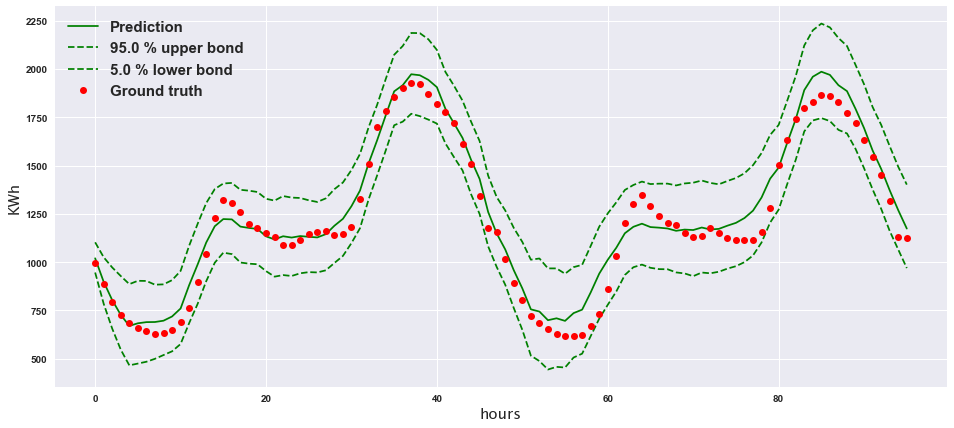

In [234]:
plot_conf(ttest, ypred_t, 1, 1.645)

**Create Std: fit error method**

In [133]:
validation_error = (val_y - ypred)  

In [140]:
emhgb = RegressorChain(hgb)
%time emhgb.fit(val_X, validation_error**2)

CPU times: user 4min 40s, sys: 51.6 s, total: 5min 32s
Wall time: 59.9 s


RegressorChain(base_estimator=HistGradientBoostingRegressor(l2_regularization=0.0,
                                                            learning_rate=0.1,
                                                            loss='least_squares',
                                                            max_bins=80,
                                                            max_depth=None,
                                                            max_iter=100,
                                                            max_leaf_nodes=3,
                                                            min_samples_leaf=20,
                                                            n_iter_no_change=None,
                                                            random_state=None,
                                                            scoring=None,
                                                            tol=1e-07,
                                                            validat

In [141]:
p_test_err = emhgb.predict(ftest)
test_err = pd.DataFrame(p_test_err)

In [159]:
err_mean, err_std = ci_construct(test_err**0.5, 1.645)

In [160]:
ypred_t_ub = ypred_t + err_std
ypred_t_lb = ypred_t - err_std

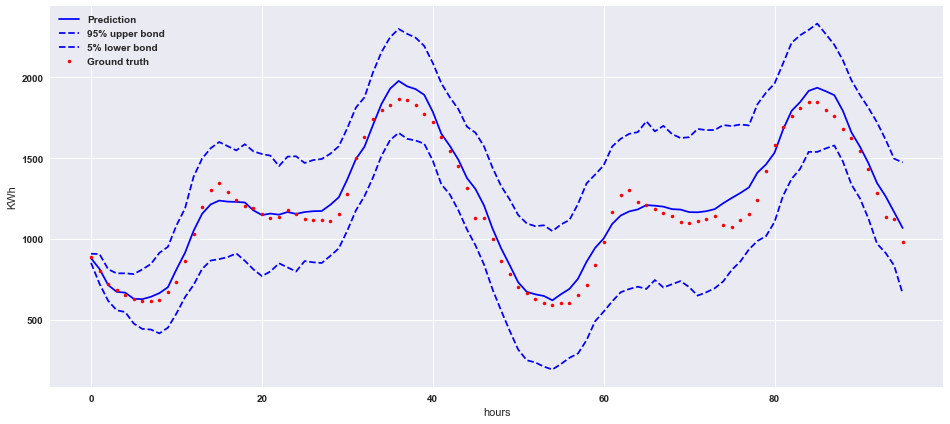

In [161]:
fig = plt.figure(figsize=(16,7))

plt.plot(ypred_t[50:51,:].reshape(-1,1), 'bx-',label='Prediction')
plt.plot(ypred_t_ub[50:51,:].reshape(-1,1), 'b--', label='95% upper bond')
plt.plot(ypred_t_lb[50:51,:].reshape(-1,1), 'b--', label='5% lower bond')
plt.plot(ttest.iloc[50:51,:].to_numpy().reshape(-1,1), 'r.', label='Ground truth', lw = 3)
#plt.fill(np.concatenate([xx, xx[::-1]]),
#         np.concatenate([y_upper, y_lower[::-1]]),
#         alpha=.5, fc='b', ec='None', label='90% prediction interval')
plt.xlabel('hours')
plt.ylabel('KWh')
plt.legend(loc='upper left')
plt.show()

### Gradient Boosting Regression

In [173]:
from sklearn.ensemble import GradientBoostingRegressor
# lower bond
gbr_lb = GradientBoostingRegressor(loss='quantile', learning_rate=0.1, 
                                n_estimators=100, subsample=1.0, 
                                criterion='friedman_mse', min_samples_split=2, 
                                min_samples_leaf=1, min_weight_fraction_leaf=0.0, 
                                max_depth=3, min_impurity_decrease=0.0, 
                                min_impurity_split=None, init=None, 
                                random_state=None, max_features=None, 
                                alpha=0.95, verbose=0, 
                                max_leaf_nodes=None, warm_start=False, 
                                presort='deprecated', validation_fraction=0.1, 
                                n_iter_no_change=None, tol=0.0001, 
                                ccp_alpha=0.0)
mlr_lb = MultiOutputRegressor(gbr_lb, n_jobs=4)
# upper bond
gbr_ub = GradientBoostingRegressor(loss='quantile', learning_rate=0.1, 
                                n_estimators=100, subsample=1.0, 
                                criterion='friedman_mse', min_samples_split=2, 
                                min_samples_leaf=1, min_weight_fraction_leaf=0.0, 
                                max_depth=3, min_impurity_decrease=0.0, 
                                min_impurity_split=None, init=None, 
                                random_state=None, max_features=None, 
                                alpha=0.05, verbose=0, 
                                max_leaf_nodes=None, warm_start=False, 
                                presort='deprecated', validation_fraction=0.1, 
                                n_iter_no_change=None, tol=0.0001, 
                                ccp_alpha=0.0)
mlr_ub = MultiOutputRegressor(gbr_ub, n_jobs=4)
# prediction
gbr = GradientBoostingRegressor(loss='ls', learning_rate=0.1, 
                                n_estimators=100, subsample=1.0, 
                                criterion='friedman_mse', min_samples_split=2, 
                                min_samples_leaf=1, min_weight_fraction_leaf=0.0, 
                                max_depth=3, min_impurity_decrease=0.0, 
                                min_impurity_split=None, init=None, 
                                random_state=None, max_features=None, 
                                verbose=0, 
                                max_leaf_nodes=None, warm_start=False, 
                                presort='deprecated', validation_fraction=0.1, 
                                n_iter_no_change=None, tol=0.0001, 
                                ccp_alpha=0.0)
mlr = MultiOutputRegressor(gbr, n_jobs=4)


In [174]:
from sklearn.model_selection import train_test_split
X = mt_feature
y = ttrain
train_X, val_X, train_y, val_y = train_test_split(X, y, train_size = 0.7, test_size = 0.3)

%time mlr.fit(train_X, train_y)
%time mlr_lb.fit(train_X, train_y)
%time mlr_ub.fit(train_X, train_y)

CPU times: user 575 ms, sys: 164 ms, total: 739 ms
Wall time: 3min
CPU times: user 534 ms, sys: 97.3 ms, total: 631 ms
Wall time: 3min 9s
CPU times: user 601 ms, sys: 110 ms, total: 711 ms
Wall time: 3min 34s


MultiOutputRegressor(estimator=GradientBoostingRegressor(alpha=0.05,
                                                         ccp_alpha=0.0,
                                                         criterion='friedman_mse',
                                                         init=None,
                                                         learning_rate=0.1,
                                                         loss='quantile',
                                                         max_depth=3,
                                                         max_features=None,
                                                         max_leaf_nodes=None,
                                                         min_impurity_decrease=0.0,
                                                         min_impurity_split=None,
                                                         min_samples_leaf=1,
                                                         min_samples_split=2,
             

### Validation set

In [176]:
ypred_lb = mlr_lb.predict(val_X[:5,:])
ypred_ub = mlr_ub.predict(val_X[:5,:])
ypred = mlr.predict(val_X[:5,:])

**Metrics**

In [189]:
o_y = np.transpose(val_y.iloc[1:2,:].to_numpy())
p_y = np.transpose(ypred[1:2,:])
get_eval(o_y, p_y)

MSE: 5643.713135244133
MAE: 50.41346131426601
r2_score: 0.9397071122036978


**Visualization**

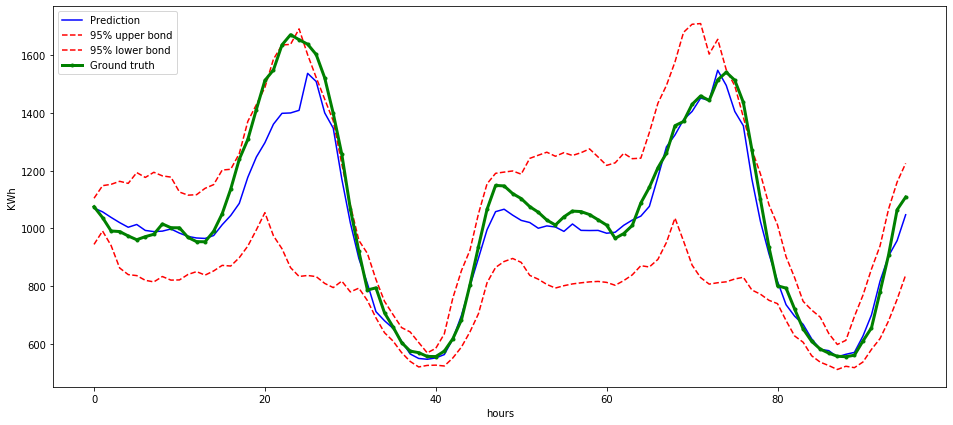

In [190]:
fig = plt.figure(figsize=(16,7))

plt.plot(ypred[1:2,:].reshape(-1,1), 'b-',label='Prediction')
plt.plot(ypred_ub[1:2,:].reshape(-1,1), 'r--', label='95% upper bond')
plt.plot(ypred_lb[1:2,:].reshape(-1,1), 'r--', label='95% lower bond')
plt.plot(val_y.iloc[1:2,:].to_numpy().reshape(-1,1), 'g.-', label='Ground truth', lw = 3)
#plt.fill(np.concatenate([xx, xx[::-1]]),
#         np.concatenate([y_upper, y_lower[::-1]]),
#         alpha=.5, fc='b', ec='None', label='90% prediction interval')
plt.xlabel('hours')
plt.ylabel('KWh')
plt.legend(loc='upper left')
plt.show()

### Testing set

In [191]:
## feature scaling
# single_test = pd.concat([single_wt, ahead_et], axis = 1) ## without weather recency effect
## with weather recency effect
mtest = mmscaler.transform(ftest)

## feature pick up
test_x = mtest[:,cols]
test_y = ttest

In [192]:
ypred_t_lb = mlr_lb.predict(test_x[:5,:])
ypred_t_ub = mlr_ub.predict(test_x[:5,:])
ypred_t = mlr.predict(test_x[:5,:])

**Metrics**

In [200]:
o_yt = np.transpose(test_y.iloc[3:4,:].to_numpy())
p_yt = np.transpose(ypred_t[4:5,:])
get_eval(o_yt, p_yt)

MSE: 28158.256035499897
MAE: 127.15439794948765
r2_score: 0.8271237981199482


**Visualization**


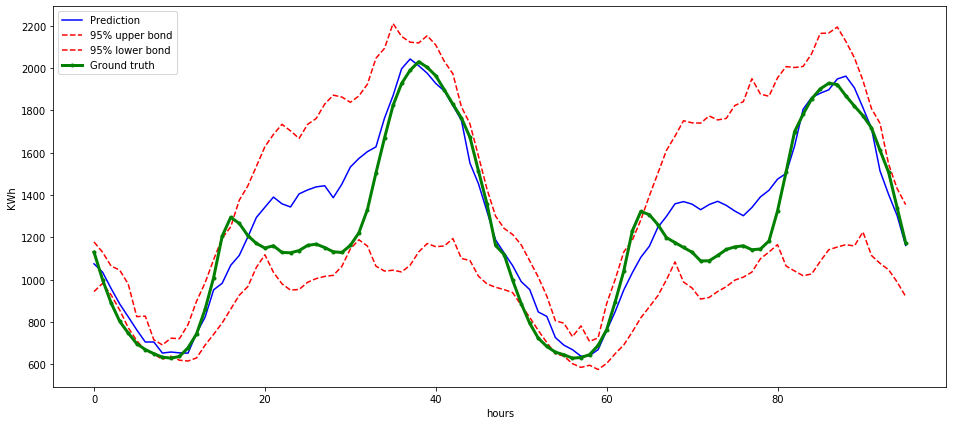

In [194]:
fig = plt.figure(figsize=(16,7))

plt.plot(ypred_t[0:1,:].reshape(-1,1), 'b-',label='Prediction')
plt.plot(ypred_t_ub[0:1,:].reshape(-1,1), 'r--', label='95% upper bond')
plt.plot(ypred_t_lb[0:1,:].reshape(-1,1), 'r--', label='95% lower bond')
plt.plot(test_y.iloc[0:1,:].to_numpy().reshape(-1,1), 'g.-', label='Ground truth', lw = 3)
#plt.fill(np.concatenate([xx, xx[::-1]]),
#         np.concatenate([y_upper, y_lower[::-1]]),
#         alpha=.5, fc='b', ec='None', label='90% prediction interval')
plt.xlabel('hours')
plt.ylabel('KWh')
plt.legend(loc='upper left')
plt.show()



### Random Forest Regression: Manual ML

In [128]:
from sklearn.ensemble import RandomForestRegressor

X = mt_feature
y = ttrain

train_X, val_X, train_y, val_y = train_test_split(X, y, train_size = 0.7, test_size = 0.3)

rfr = RandomForestRegressor(max_depth=15, random_state=1, n_estimators=100)
rfr.fit(train_X, train_y)


RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=15, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=100, n_jobs=None, oob_score=False,
                      random_state=1, verbose=0, warm_start=False)

In [129]:
yhat = rfr.predict(val_X)

### Result evaluation: validation set

**Metrics**


In [130]:
get_eval(val_y, yhat)

MSE: 8070.397340377949
MAE: 46.609515140911675
r2_score: 0.9704237803369036


**Visualization**

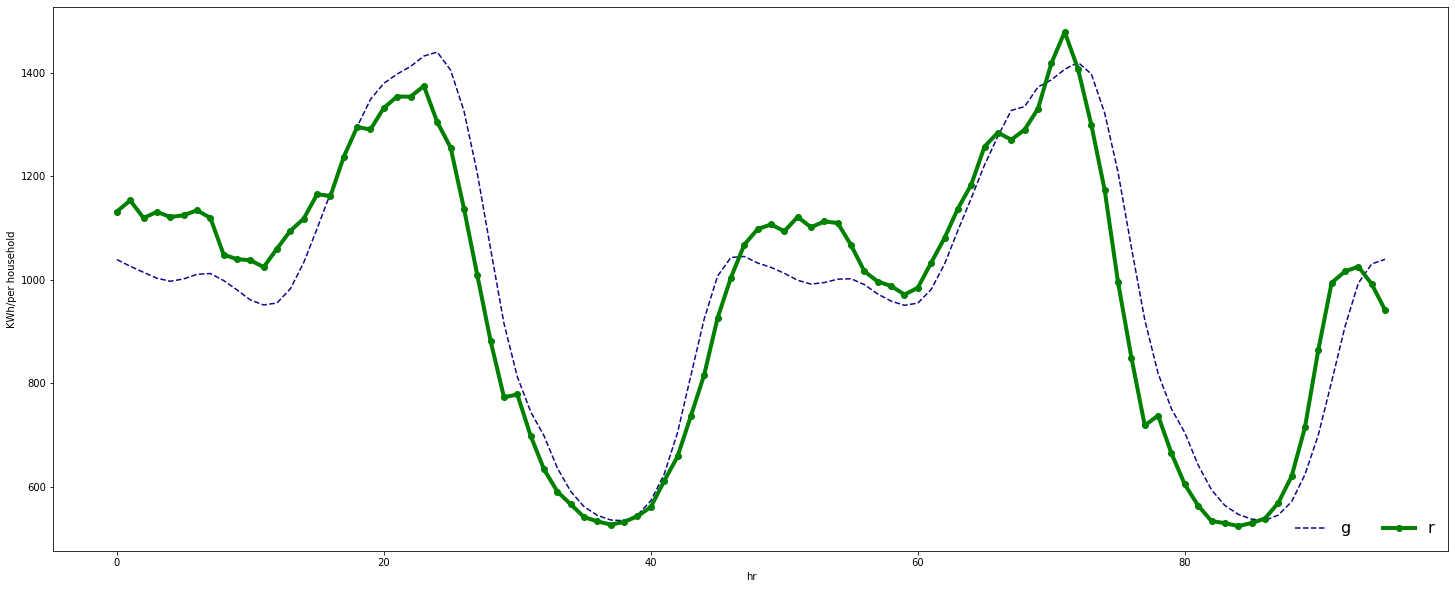

In [132]:
## assignment
real = val_y.to_numpy()
guess = yhat
real = real[:1,:96]
guess = guess[:1,:96]
rpdf = plot_df(real, "r")
gpdf = plot_df(guess, "g")
    
#plot 
ax = plt.gca()
gpdf.plot(figsize=(25,10), colormap = 'plasma',style='--',legend = True, ax = ax)
rpdf.plot(figsize=(25,10), color = 'g',style ='-o',legend = True, ax = ax, lw = 4)
ax.set_xlabel("hr")
ax.set_ylabel("KWh/per household")
ax.legend(frameon=False, loc='lower right', ncol=6, prop={'size': 16})

plt.show()

### Result evaluation: test set

**Data preparation for test set**

- prepare recency features
- feature scaling 
- identify feature picked from previous training process

In [133]:
## feature scaling
# single_test = pd.concat([single_wt, ahead_et], axis = 1) ## without weather recency effect
## with weather recency effect
mtest = mmscaler.transform(ftest)

## feature pick up
test_x = mtest[:,cols]
test_y = ttest

In [134]:
## Prediction with test data
yt_hat = rfr.predict(test_x)

**Performance**

In [135]:
get_eval(test_y, yt_hat)

MSE: 11011.348133882544
MAE: 73.67232610418345
r2_score: 0.9307518864317372


**Visualization**

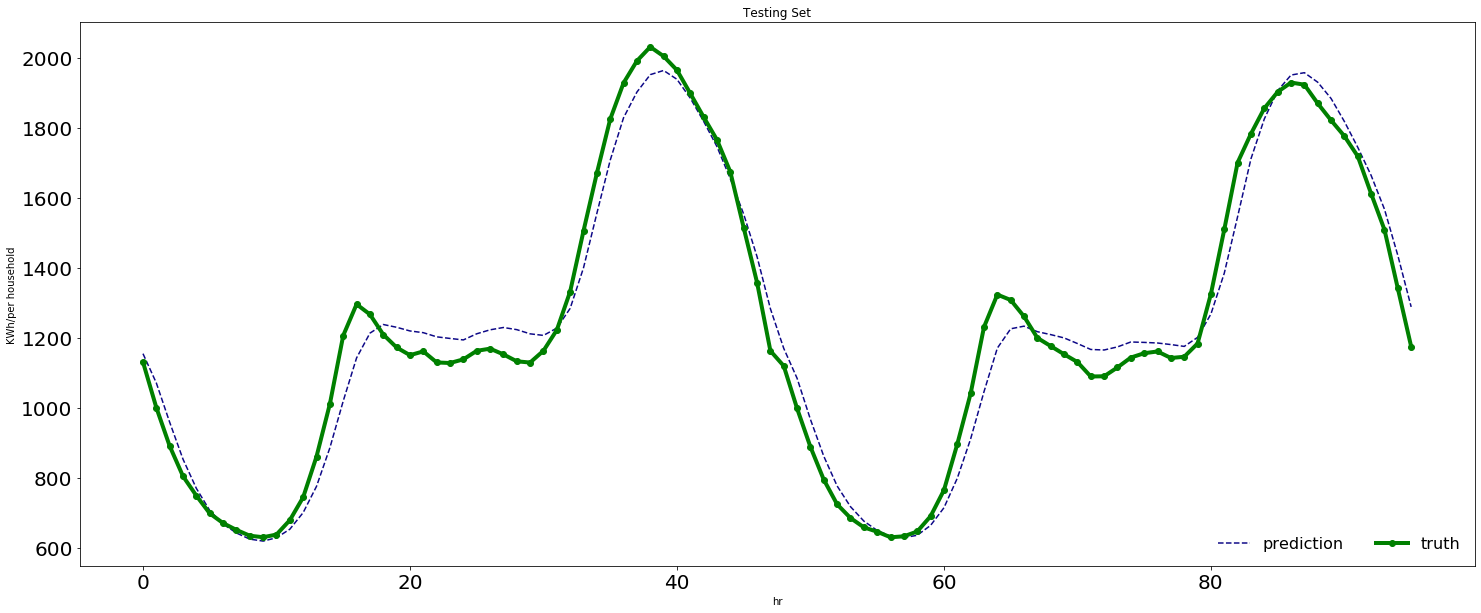

In [136]:
real = test_y.to_numpy()
guess = yt_hat
real = real[0:1,:96]
guess = guess[0:1,:96]
rpdf = plot_df(real,"truth")
gpdf = plot_df(guess,"prediction")
    
#plot 
ax = plt.gca()
ax.title.set_size(20)

gpdf.plot(title = "Testing Set", figsize=(25,10), colormap = 'plasma',style='--',legend = True, ax = ax,fontsize= 20)
rpdf.plot(figsize=(25,10), color = 'g',style ='-o',legend = True, ax = ax,lw = 4)
ax.set_xlabel("hr")
ax.set_ylabel("KWh/per household")
ax.legend(frameon=False, loc='lower right', ncol=6, prop={'size': 16})

plt.show()

### Xgboost: Manual

In [137]:
import xgboost as xgb
from sklearn.multioutput import MultiOutputRegressor

X = mt_feature
y = ttrain
train_X, val_X, train_y, val_y = train_test_split(X, y, train_size = 0.7, test_size = 0.3)

xgbr = xgb.XGBRegressor(max_depth=10, njobs= 4)
mr = MultiOutputRegressor(xgbr, n_jobs = 4)
mr.fit(train_X, train_y)
#rc = MultiOutputRegressor(xgbr, cv = 5, random_state = 123)
#rc.fit(train_X, train_y)

MultiOutputRegressor(estimator=XGBRegressor(base_score=0.5, booster='gbtree',
                                            colsample_bylevel=1,
                                            colsample_bynode=1,
                                            colsample_bytree=1, gamma=0,
                                            importance_type='gain',
                                            learning_rate=0.1, max_delta_step=0,
                                            max_depth=10, min_child_weight=1,
                                            missing=None, n_estimators=100,
                                            n_jobs=1, njobs=4, nthread=None,
                                            objective='reg:linear',
                                            random_state=0, reg_alpha=0,
                                            reg_lambda=1, scale_pos_weight=1,
                                            seed=None, silent=None, subsample=1,
                                        

### Result evaluation: test set

In [138]:
yhat = mr.predict(val_X)

In [139]:
get_eval(val_y, yhat)

MSE: 6782.631476369782
MAE: 41.96216382445107
r2_score: 0.97505903984617


**Visualization**

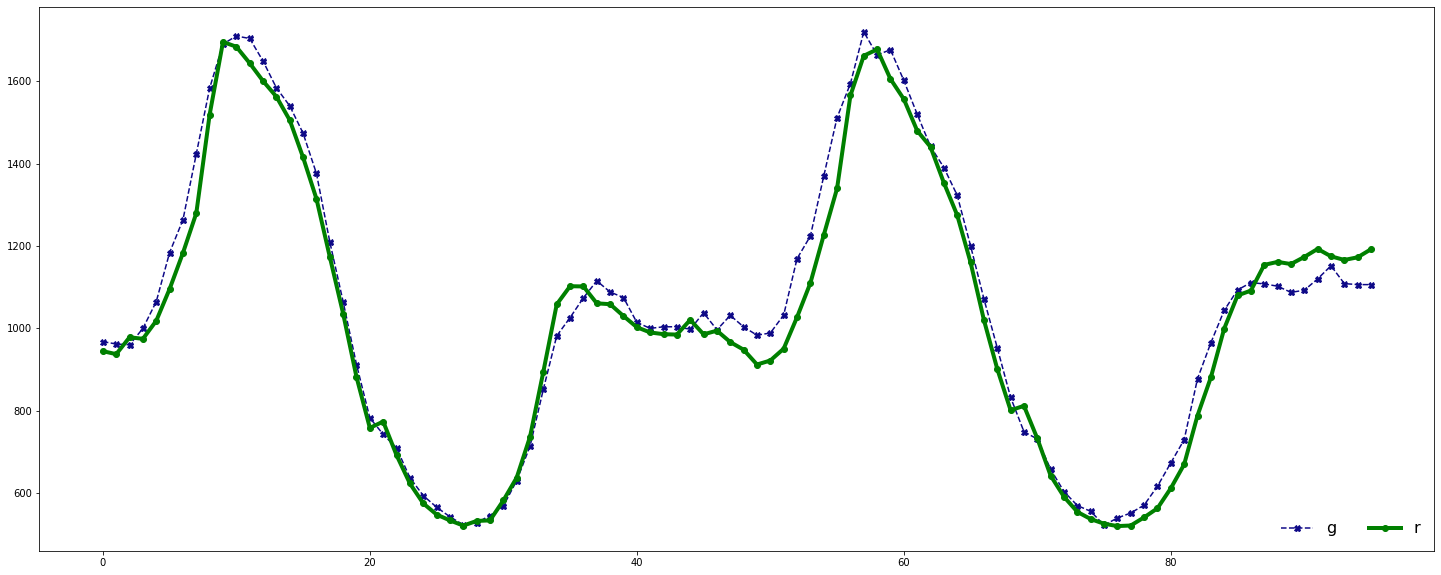

In [144]:
real = val_y.to_numpy()
guess = yhat
real = real[1:2,:96]
guess = guess[1:2,:96]
rpdf = plot_df(real,"r")
gpdf = plot_df(guess,"g")
    
#plot 
ax = plt.gca()
gpdf.plot(figsize=(25,10), colormap = 'plasma',style='--X',legend = True, ax = ax)
rpdf.plot(figsize=(25,10), color = 'g',style ='-o',legend = True, ax = ax,lw = 4)
ax.legend(frameon=False, loc='lower right', ncol=6, prop={'size': 16})
    
plt.show()

### Result evaluation: test set

In [145]:
yhat = mr.predict(test_x)

In [146]:
get_eval(test_y, yhat)

MSE: 11403.41431283326
MAE: 73.57078548833333
r2_score: 0.9282862625175581


**Visualization**


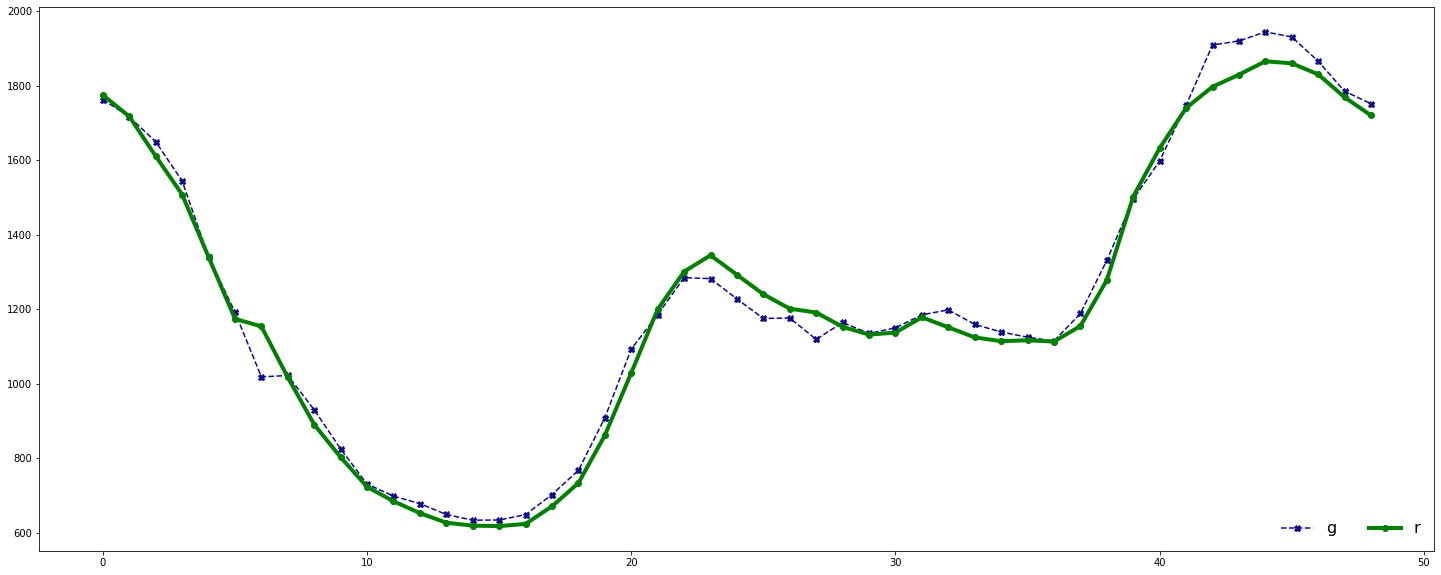

In [147]:
real = test_y.to_numpy()
guess = yhat
real = real[90:91,:49]
guess = guess[90:91,:49]
rpdf = plot_df(real,"r")
gpdf = plot_df(guess,"g")
    
#plot 
ax = plt.gca()
gpdf.plot(figsize=(25,10), colormap = 'plasma',style='--X',legend = True, ax = ax)
rpdf.plot(figsize=(25,10), color = 'g',style ='-o',legend = True, ax = ax,lw = 4)
ax.legend(frameon=False, loc='lower right', ncol=6, prop={'size': 16})
    
plt.show()

### LSTM

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_7 (LSTM)                (None, 1, 50)             12200     
_________________________________________________________________
time_distributed_7 (TimeDist (None, 1, 96)             4896      
Total params: 17,096
Trainable params: 17,096
Non-trainable params: 0
_________________________________________________________________
Epoch 1/50
 - 3s - loss: 933457.9555
Epoch 2/50
 - 2s - loss: 693238.6110
Epoch 3/50
 - 2s - loss: 392925.0733
Epoch 4/50
 - 2s - loss: 193871.5715
Epoch 5/50
 - 2s - loss: 120083.6844
Epoch 6/50
 - 2s - loss: 104187.8377
Epoch 7/50
 - 2s - loss: 100139.4633
Epoch 8/50
 - 2s - loss: 97760.6811
Epoch 9/50
 - 2s - loss: 96170.4118
Epoch 10/50
 - 2s - loss: 94961.4260
Epoch 11/50
 - 2s - loss: 93849.1502
Epoch 12/50
 - 2s - loss: 92949.5286
Epoch 13/50
 - 2s - loss: 92296.0201
Epoch 14/50
 - 2s - loss: 91801.8

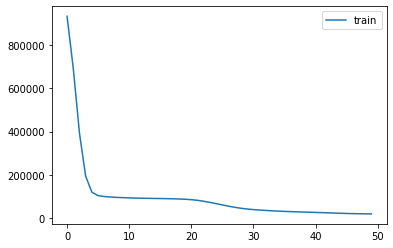

In [149]:
from keras.layers import TimeDistributed
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM

train_X, val_X, train_y, val_y = train_test_split(mt_feature, ttrain, train_size = 0.7, test_size = 0.3)
ltrain_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
lval_X = val_X.reshape((val_X.shape[0], 1, val_X.shape[1]))
ltrain_y = train_y.to_numpy().reshape((train_y.shape[0],1, train_y.shape[1]))

# design network
model = Sequential()
model.add(LSTM(50, activation='relu', input_shape=(ltrain_X.shape[1], ltrain_X.shape[2]),return_sequences = True))
model.add(TimeDistributed(Dense(96)))
model.compile(loss='mean_squared_error', optimizer='adam')
model.summary()
# fit network
history = model.fit(ltrain_X, ltrain_y, epochs=50, batch_size=72, verbose=2, shuffle=False)
# plot history
plt.plot(history.history['loss'], label='train')
plt.legend()
plt.show()

### Validation sets

**Metrics**


In [150]:
yhat = model.predict(val_X.reshape(val_X.shape[0], 1, val_X.shape[1]))
yhat = yhat.reshape(yhat.shape[0], yhat.shape[2])

In [153]:
get_eval(val_y, yhat)

MSE: 19529.31616290541
MAE: 82.99164153984434
r2_score: 0.9284311890208347


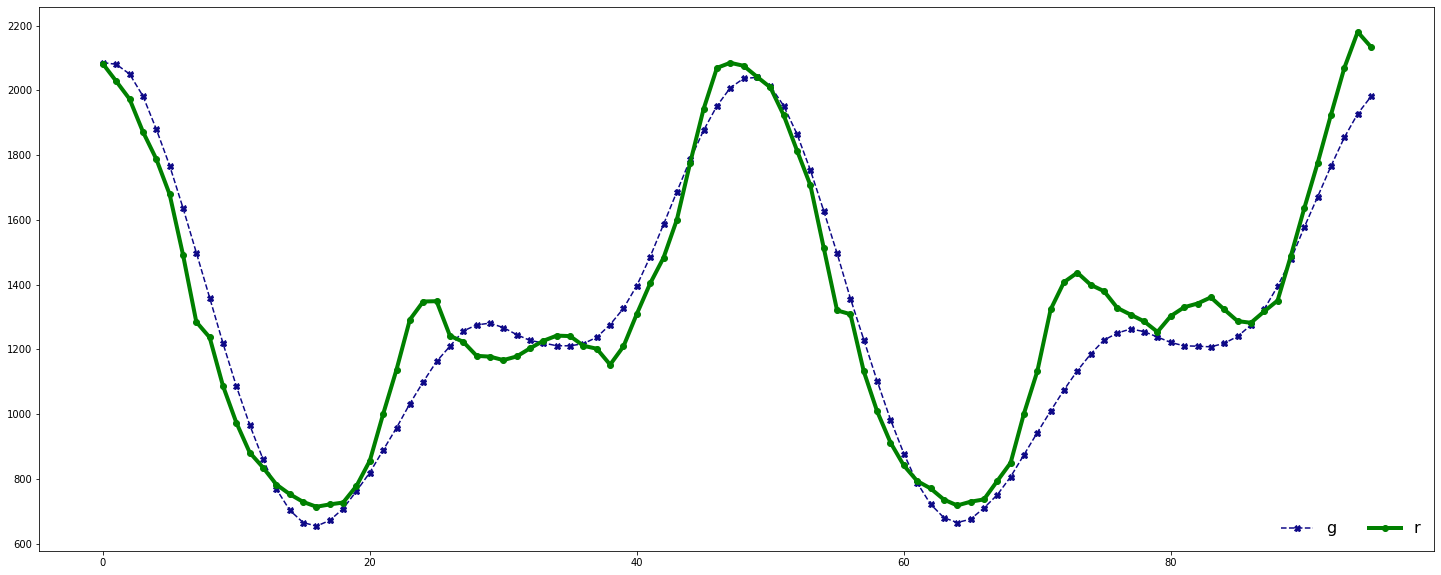

In [157]:
real = val_y.to_numpy()
guess = yhat
real = real[1:2,:96]
guess = guess[1:2,:96]
rpdf = plot_df(real,"r")
gpdf = plot_df(guess,"g")
    
#plot 
ax = plt.gca()
gpdf.plot(figsize=(25,10), colormap = 'plasma',style='--X',legend = True, ax = ax)
rpdf.plot(figsize=(25,10), color = 'g',style ='-o',legend = True, ax = ax,lw = 4)
ax.legend(frameon=False, loc='lower right', ncol=6, prop={'size': 16})
    
plt.show()

### Testing sets

In [158]:
yhat = model.predict(test_x.reshape(test_x.shape[0], 1, test_x.shape[1]))
yhat = yhat.reshape(yhat.shape[0], yhat.shape[2])

**Metrics**

In [159]:
get_eval(test_y.iloc[:1,:].to_numpy().reshape(-1,1), yhat[:1,:].reshape(-1,1))

MSE: 18457.877717528554
MAE: 99.613075093571
r2_score: 0.8867621714987617


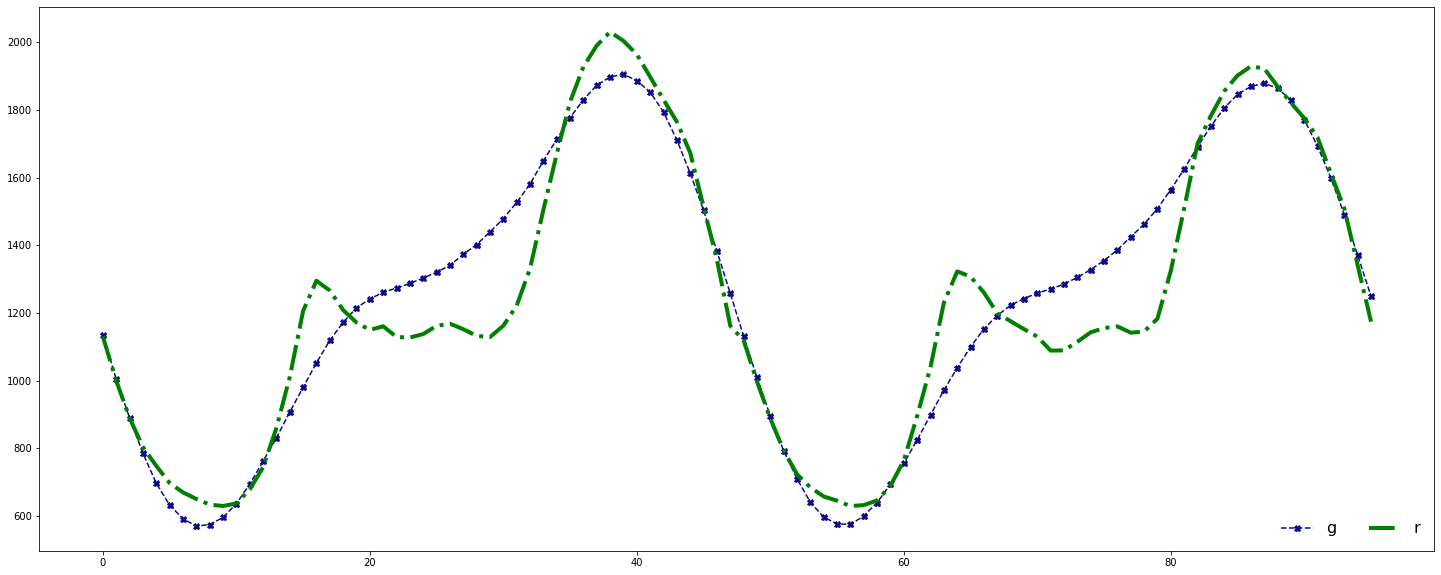

In [170]:
real = test_y.to_numpy()
guess = yhat
real = real[0:1,:96]
guess = guess[0:1,:96]
rpdf = plot_df(real,"r")
gpdf = plot_df(guess,"g")
    
#plot 
ax = plt.gca()
gpdf.plot(figsize=(25,10), colormap = 'plasma',style='--X',legend = True, ax = ax)
rpdf.plot(figsize=(25,10), color = 'g',style ='-.',legend = True, ax = ax,lw = 4)
ax.legend(frameon=False, loc='lower right', ncol=6, prop={'size': 16})
    
plt.show()